In [1]:
from pyspark.sql.functions import mean, udf, col, round
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

df1 = spark.read.csv('data/pluto.csv', header=True)
df2 = spark.read.csv('data/pluto_18v1.csv', header=True)

df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])

double_columns = ['bldgarea', 'facilfar','residfar', 'commfar', 
                  'numbldgs', 'numfloors', 'bldgdepth','bldgfront', 
                  'lotdepth', 'lotfront','exemptland', 'exempttot', 
                  'assessland', 'assesstot','builtfar']
cols = df2.columns
df1 = df1.select(cols)
df2 = df2.select(cols)

for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))
    

df1 = df1.select([col(A).alias(A+'_1') for A in df1.schema.names])

colnames = zip(df1.columns, df2.columns)

df = df2.join(df1, df2['bbl'] == df1['bbl_1'])

In [2]:
@udf
def compare(col1,col2):
    if col1!=col2:
        return 1
    else:
        return 0
    
access_cols = ['exemptland', 'exempttot', 'assessland', 'assesstot']

@udf #special access column comparison
def compare_a(col1,col2):
    try: 
        if abs(col1 - col2) > 10: 
            return 1
        else: 
            return 0
    except: 
        return 0

In [3]:
spark.sql('set spark.sql.caseSensitive=true')
for A,B in colnames:
    if B in access_cols:
        df = df.withColumn(B+'%', compare_a(col(A),col(B)))\
               .drop(A,B)
    else:
        df = df.withColumn(B+'%', compare(col(A),col(B)))\
                   .drop(A,B)
        
results = df.select(*[mean(col(A)).alias(A) for A in df.columns])

In [4]:
start_time = time.time()
results_df = results.toPandas()
elapsed_time = time.time() - start_time

In [5]:
results_df.iloc[0,:].sort_values(ascending=False)[0:30]

version%       1.000000
exempttot%     0.116046
ownertype%     0.103721
exemptland%    0.079357
resarea%       0.060490
comarea%       0.058747
retailarea%    0.058083
officearea%    0.057725
otherarea%     0.057354
garagearea%    0.057166
factryarea%    0.057063
strgearea%     0.057037
ownername%     0.054503
bsmtcode%      0.052244
areasource%    0.039001
ycoord%        0.037079
xcoord%        0.036882
sanitsub%      0.027707
address%       0.025827
cb2010%        0.023832
zonedist2%     0.021940
splitzone%     0.020735
zipcode%       0.019434
builtfar%      0.017985
landuse%       0.015950
bldgarea%      0.014562
sanitboro%     0.014334
histdist%      0.011170
spdist1%       0.008916
numbldgs%      0.008770
Name: 0, dtype: float64

In [6]:
results0 = pd.read_csv('results_17v11_18v1.csv', index_col = False)

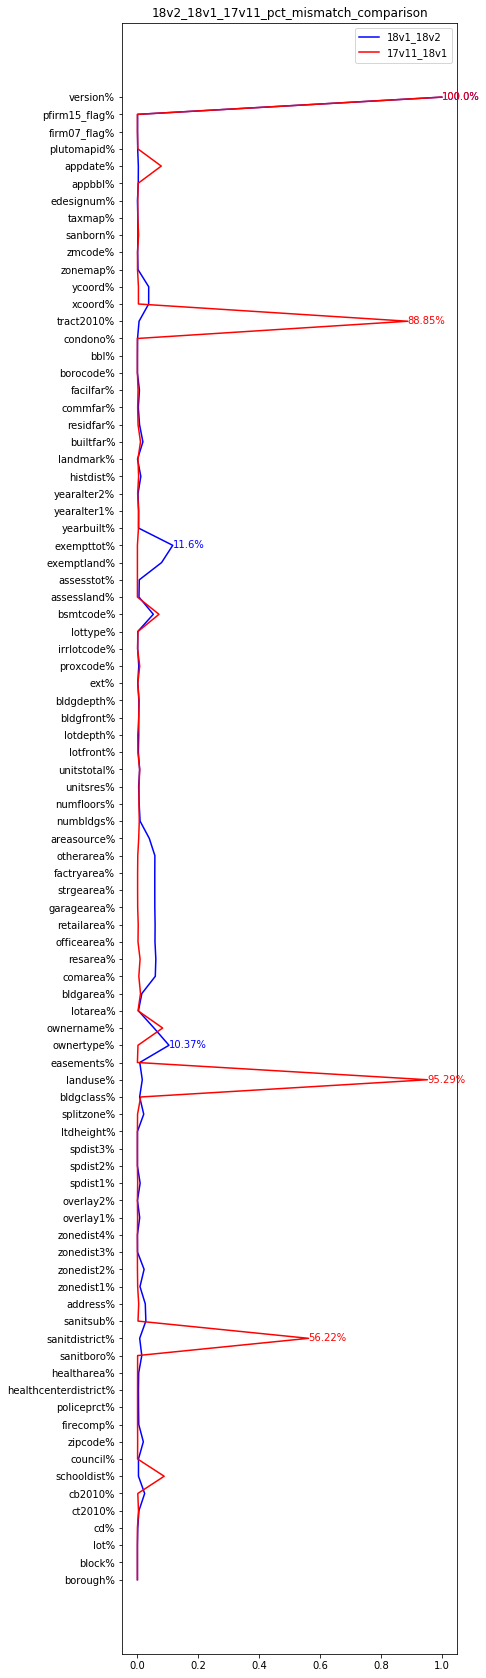

In [7]:
plt.figure(figsize=(6, 30))
plt.plot(results_df.iloc[0, :], range(87), label = '18v1_18v2', color = 'blue')
plt.plot(results0.iloc[0, :], range(87), label = '17v11_18v1', color = 'red')
label = list(results_df.iloc[0, :])
label0 = list(results0.iloc[0, :])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass
    
for i in range(len(label0)):
    if label0[i] >= 0.1:
        plt.text(x = label0[i] , y = i-0.15, s = '{}%'.format(np.round(label0[i]*100, 2)), size = 10, color = 'red')
    else: 
        pass
    
plt.yticks(range(87), results_df.columns, rotation='horizontal')
plt.legend()
plt.title('18v2_18v1_17v11_pct_mismatch_comparison')
plt.savefig('18v2_18v1_17v11_pct_mismatch_comparison.png', bbox_inches='tight')
plt.show()